In [23]:
import json
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [24]:
df = pd.read_pickle("per_chapter_train_split_stats.pkl")
df = df[["word_count", "sentence_count", "paragraph_count", "chapter_count", "book"]]
df.head()

,word_count,sentence_count,paragraph_count,chapter_count,book
0,1011,36,15,5,abraham/fabeln/fabeln.html
0,21003,634,117,55,abraham/fabparab/fabparab.html
0,9302,406,82,19,abraham/misc/misc.html
0,13506,391,80,12,abraham/narrnest/narrnest.html
0,147207,6325,1716,68,achleitn/bergen/bergen.html


In [25]:
def book_to_filename(string: str) -> str:
    author, book, _ = tuple(string.split("/"))
    return f"{author}_{book}.json"

novels = []
for book in df["book"]:
    with open(f"../corpus/{book_to_filename(book)}", "r") as f:
        genre = json.load(f)["genre"]
    if genre == "Romane, Novellen und Erzählungen":
        novels.append(book)

# df = df[df["book"].isin(novels)]


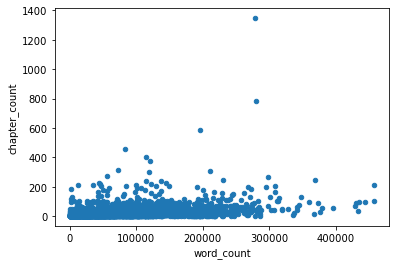

In [26]:
df.plot.scatter(x="word_count", y="chapter_count")
plt.show()

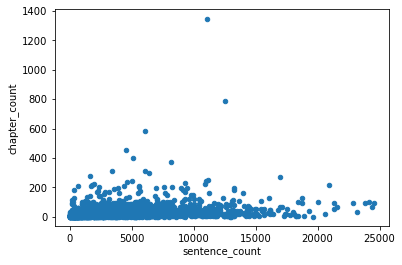

In [27]:
df.plot.scatter(x="sentence_count", y="chapter_count")
plt.show()

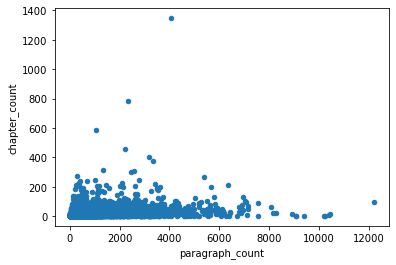

In [28]:
df.plot.scatter(x="paragraph_count", y="chapter_count")
plt.show()

In [29]:
df.corr(method="spearman")

,word_count,sentence_count,paragraph_count,chapter_count
word_count,1.000000,0.911290,0.775232,0.452330
sentence_count,0.911290,1.000000,0.883038,0.435450
paragraph_count,0.775232,0.883038,1.000000,0.394247
chapter_count,0.452330,0.435450,0.394247,1.000000


In [30]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


def regress_and_plot(df, column):
    x = np.array(df[column]).reshape(-1, 1)
    y = np.array(df["chapter_count"]).reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, random_state=6948050
    )
    # fit
    model = linear_model.LinearRegression(fit_intercept=True)
    model.fit(x_train, y_train)
    # predict
    y_pred = model.predict(x_test)
    print(y_pred[:5])

    print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )

    plt.scatter(x_test, y_test, color="black")
    plt.plot(x_test, y_pred, color="blue")
    plt.xlabel(column)
    plt.ylabel("chapter_count")
    plt.show()

[[13.54404458]
 [14.80877283]
 [16.54667837]
 [29.81787929]
 [38.91921877]]
RMSE: 29.92 MSE: 895.03 MAE: 15.264 R2: 0.14368837443217408


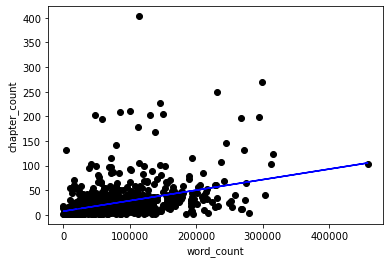

[[17.87373362]
 [18.09500696]
 [21.33931053]
 [27.41030319]
 [28.60704917]]
RMSE: 30.49 MSE: 929.35 MAE: 15.81 R2: 0.11085107390009241


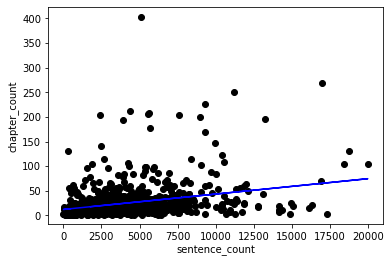

[[22.16628786]
 [22.55281849]
 [25.19618926]
 [27.81462257]
 [23.23236428]]
RMSE: 31.2 MSE: 973.68 MAE: 16.359 R2: 0.068442909363431


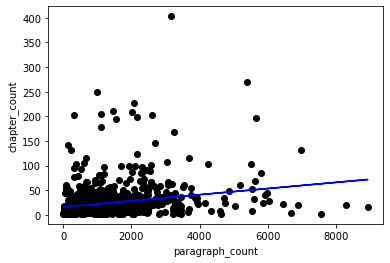

In [31]:
regress_and_plot(df, "word_count")
regress_and_plot(df, "sentence_count")
regress_and_plot(df, "paragraph_count")

In [32]:
# multiple linear regression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

x = zip(df["word_count"], df["sentence_count"], df["paragraph_count"])
x = np.array(list(x))
y = np.array(df["chapter_count"]).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=6948050
)
# fit
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
print("Word Count, Sentence Count, Paragraph Count")
print(model.coef_)
print(model.intercept_)
# predict
y_pred = model.predict(x_test)
print(y_pred[:10])

print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )

Word Count, Sentence Count, Paragraph Count
[[ 0.00031836 -0.00154716 -0.00205627]]
[8.19649604]
[[12.23776967]
 [13.88355543]
 [13.98876654]
 [29.87147794]
 [44.34020187]
 [45.19986931]
 [20.68682055]
 [22.72766108]
 [29.49792764]
 [24.18492248]]
RMSE: 30.05 MSE: 903.03 MAE: 15.42 R2: 0.13603323763099406


In [33]:
pred_df = pd.read_pickle("../results/predictions_finetuned_2e-5_bs32_e3_best.pkl")

In [34]:
from scipy.signal import argrelmin, find_peaks, argrelmax
import math

maxima_stats = []
for name, group in pred_df.groupby(["book_path"]):
    chapter_count = group["chapter_idx"].max()
    confidences = np.array(group["logit_0"])
    maxima = argrelmax(confidences)[0]
    candidates = group[group["logit_0"] > group["logit_1"]]
    normalized_logit_0 = (group["logit_0"] - group["logit_0"].min())/(group["logit_0"].max() - group["logit_0"].min())
    log_confidence = [-math.log(1 - l + 1e-10) for l in normalized_logit_0]
    log_threshold_candidates = [c > 0.99 for c in log_confidence]
    maxima_stats.append(
        {
            "book_path": name,
            "chapter_count": chapter_count,
            "maxima_count": len(maxima),
            "candidate_count": len(candidates),
            "log_candidate_count": len(log_threshold_candidates)
        }
    )

maxima_df = pd.DataFrame(maxima_stats)
maxima_df.head()

,book_path,chapter_count,maxima_count,candidate_count,log_candidate_count
0,about_bergkoen.json,9,321,110,1058
1,about_parisehe.json,12,372,104,1286
2,abraham_fabeln.json,4,4,7,14
3,abraham_narrnest.json,11,23,45,79
4,achleitn_bezirks1.json,4,335,68,1170


In [35]:
novels = []
for book in maxima_df["book_path"]:
    with open(f"../corpus/{book}", "r") as f:
        genre = json.load(f)["genre"]
    if genre == "Romane, Novellen und Erzählungen":
        novels.append(book)

# maxima_df = maxima_df[maxima_df["book_path"].isin(novels)]

In [36]:
maxima_df.sort_values(by="chapter_count", ascending=False).head()

,book_path,chapter_count,maxima_count,candidate_count,log_candidate_count
878,schoeppn_bysagen.json,1345,1231,1973,4058
618,lespinas_briefe.json,226,663,662,2079
868,schmid_erzjugen.json,202,113,219,325
385,grimm_maerchen.json,198,663,492,2149
437,hebel_hausfreu.json,190,161,258,514


In [37]:
maxima_df = maxima_df[maxima_df["book_path"] != "schoeppn_bysagen.json"]

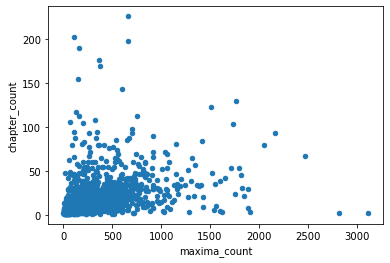

In [38]:
maxima_df.plot.scatter(x="maxima_count", y="chapter_count")
plt.show()

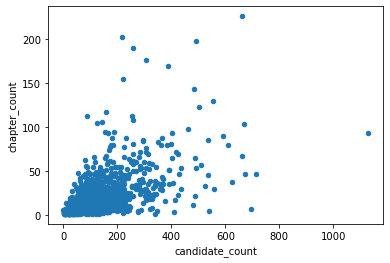

In [39]:
maxima_df.plot.scatter(x="candidate_count", y="chapter_count")
plt.show()

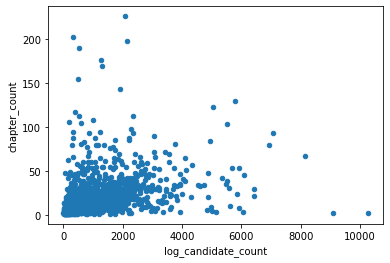

In [40]:
maxima_df.plot.scatter(x="log_candidate_count", y="chapter_count")
plt.show()

In [41]:
maxima_df[["maxima_count", "candidate_count", "log_candidate_count", "chapter_count"]].corr(method="spearman")

,maxima_count,candidate_count,log_candidate_count,chapter_count
maxima_count,1.000000,0.726252,0.998886,0.440371
candidate_count,0.726252,1.000000,0.720336,0.596316
log_candidate_count,0.998886,0.720336,1.000000,0.434833
chapter_count,0.440371,0.596316,0.434833,1.000000


[[24.18333503]
 [21.78177788]
 [17.55368431]
 [22.25532436]
 [20.20892707]]
RMSE: 23.59 MSE: 556.41 MAE: 13.29 R2: 0.09957711572028527


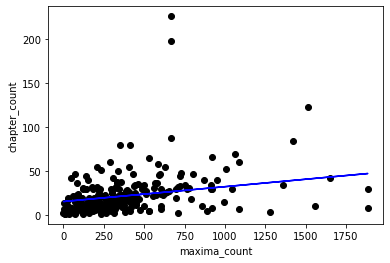

[[64.09238689]
 [24.13683026]
 [23.18550748]
 [34.00680407]
 [47.44423829]]
RMSE: 20.24 MSE: 409.81 MAE: 11.855 R2: 0.33681238558946514


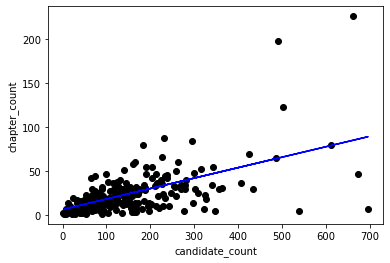

[[23.85628304]
 [21.80743905]
 [17.68941516]
 [21.85319487]
 [19.83993875]]
RMSE: 23.62 MSE: 557.68 MAE: 13.293 R2: 0.09752197517318117


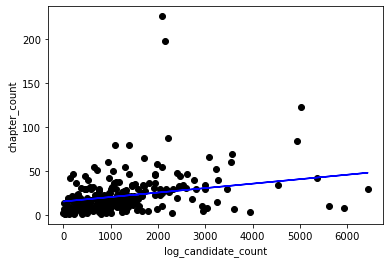

In [42]:
regress_and_plot(maxima_df, "maxima_count")
regress_and_plot(maxima_df, "candidate_count")
regress_and_plot(maxima_df, "log_candidate_count")

In [43]:
# multiple linear regression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

x = zip(maxima_df["maxima_count"], maxima_df["candidate_count"], maxima_df["log_candidate_count"])
x = np.array(list(x))
y = np.array(maxima_df["chapter_count"]).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=6948050
)
print(len(x_train))
print(len(x_test))
# fit
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
print("Maxima Count, Candidate Count, Log Candidate Count")
print(model.coef_)
print(model.intercept_)
# predict
y_pred = model.predict(x_test)
print(y_pred[:10])

print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )


949
238
Maxima Count, Candidate Count, Log Candidate Count
[[ 0.04067064  0.13765858 -0.01502779]]
[7.21239985]
[[70.40618917]
 [24.43387456]
 [25.33745646]
 [36.86306456]
 [53.44834202]
 [38.34846051]
 [14.46403374]
 [ 7.45766144]
 [26.27260457]
 [78.04973742]]
RMSE: 20.35 MSE: 414.02 MAE: 12.172 R2: 0.3300060513334603


In [44]:
# # ONLY FOR INITIAL CREATION

# import nltk
# from nltk.tokenize import word_tokenize, sent_tokenize
# import os
# import pandas as pd
# import json
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# nltk.download("punkt")

# df_list = []
# corpus_files = os.listdir("../corpus/")
# corpus_files.sort()
# print(len(corpus_files))
# train, _ = train_test_split(
#     corpus_files, train_size=0.8, shuffle=True, random_state=6948050
# )

# for file in train:
#     with open(f"../corpus/{file}", "r", encoding="utf8") as f:
#         d = json.load(f)
#         df = pd.DataFrame(d)
#         df = df.drop(columns=["author", "webpath", "title"])
#         df["filepath"] = df["filepath"].apply(
#             lambda x: x.replace(
#                 "/mnt/c/Users/Moritz Lahann/Desktop/STUDIUM/Module IAS/Master's Thesis/gutenberg-edition16/",
#                 "",
#             )
#         )
#         df_list.append(df)

# df = pd.concat(df_list)
# df.head()

# grouped_df = df.groupby(by=["filepath"])
# books_df_list = []
# for name, group in tqdm(grouped_df):
#     word_sum = sentence_sum = paragraph_sum = 0
#     for chapter in group["chapters"]:
#         word_count = sum(
#             [len(word_tokenize(p, language="german")) for p in chapter["paragraphs"]]
#         )
#         word_sum += word_count
#         sentence_count = sum(
#             [len(sent_tokenize(p, language="german")) for p in chapter["paragraphs"]]
#         )
#         sentence_sum += sentence_count
#         paragraph_count = len(chapter["paragraphs"])
#         paragraph_sum += paragraph_count

#     books_df_list.append(
#         pd.DataFrame(
#             {
#                 "paragraph_count": [paragraph_sum],
#                 "word_count": [word_sum],
#                 "sentence_count": [sentence_sum],
#                 "book": [name],
#                 "chapter_count": len(group["chapters"]),
#             }
#         )
#     )

# stats_df = pd.concat(books_df_list)
# stats_df.to_pickle("per_chapter_train_split_stats.pkl")